# Proyecto

# Libraries

In [129]:
import serial
import sys
import glob
import time
import numpy as np
import random
import scipy.stats
import matplotlib.pyplot as plt

# Environment

In [2]:
prod = True

# Functions

In [196]:
def listSerialPorts():
    """ Lists serial port names

        :raises EnvironmentError:
            On unsupported or unknown platforms
        :returns:
            A list of the serial ports available on the system
    """
    if sys.platform.startswith('win'):
        ports = ['COM%s' % (i + 1) for i in range(256)]
    elif sys.platform.startswith('linux') or sys.platform.startswith('cygwin'):
        # this excludes your current terminal "/dev/tty"
        ports = glob.glob('/dev/tty[A-Za-z]*')
    elif sys.platform.startswith('darwin'):
        ports = glob.glob('/dev/tty.*')
    else:
        raise EnvironmentError('Unsupported platform')

    result = []
    for port in ports:
        try:
            s = serial.Serial(port)
            s.close()
            result.append(port)
        except (OSError, serial.SerialException):
            pass
    return result

def connectToPort(n):
    ports = listSerialPorts()
    return serial.Serial(ports[n-1])

def readValueFromData(data):
    # +000.000/0 G S
    dataString = data.decode("utf-8").replace('\r\n','')
    # print(data)
    if dataString.endswith(' G S'):
        result = dataString.replace(' G S','').replace('/','').replace('+','')
        return float(result)
    else:
        raise Exception("Invalied format")
    
def serialRead(connection,testValue=0,testMargin=0):
    if prod:
        while True:
            try:
                connection.flushInput()
                return readValueFromData(connection.readline())
            except:
                pass
    else:
        val = np.round(testValue+np.random.uniform(-testMargin,testMargin),decimals=2)
        # print(val)
        return val

def calculateK(veff,coverage):
    k=0
    a = (1-coverage)/2
    if veff >= 200:
        k = scipy.stats.norm.ppf(1-a)-scipy.stats.norm.ppf(0.5)
    else:
        k = scipy.stats.t.ppf(1-a,int(veff))
    return k

def sigFigs(x: float, precision: int):
    x = float(x)
    precision = int(precision)

    return np.round(x, -int(np.floor(np.log10(np.abs(x)))) + (precision - 1))

# Connection

In [4]:

ports = listSerialPorts()

for i in range(0,len(ports)):
    print('{0}: {1}'.format(i+1, ports[i]))

1: /dev/tty.wlan-debug
2: /dev/tty.BT-163
3: /dev/tty.Bluetooth-Incoming-Port
4: /dev/tty.usbserial-FTDCYOPE


In [5]:
port = 4

connection = connectToPort(port)

In [6]:
# for i in range(0,10):
#     serialRead(connection)
#     time.sleep(1)

In [7]:
# connection.close()

# Procedure

Data

In [143]:
minSettlingTime = 3 # s
maxZeroTime = 30 # s

ppesa = 7950 #kg/m3

scaleDivision = 0.0001 # g
minimumCharge = 0.01 # g
nominalCalibrationMass = 200 # g
massCorrection = 0.016 # g
EMPs = { # EMP para masa E1 según la OIML R 111
    0.01: 6e-6,
    20: 8e-5,
    40: 1.6e-4,
    60: 1.6e-4,
    80: 2.4e-4,
    100: 1.60e-4,
    120: 2.4e-4,
    140: 3.4e-4,
    160: 3.2e-4,
    180: 4e-4,
    200: 3e-4
}


In [9]:
print('Iniciando procedimiento de calibración de la balanza.')
input('Presione enter para continuar.')

T0 = -200
while T0 == -200:
      try:
            T0 = float(input('Favor ingrese la temperatura en °C en este momento.'))
      except:
            print('Número inválido, favor ingrese un número válido: número racional')
            T0 = -200
            
P0 = 0
while P0 == 0:
      try:
            P0 = float(input('Favor ingrese la presión en hPa en este momento.'))
      except:
            print('Número inválido, favor ingrese un número válido: número racional positivo')
            P0 = 0
            
HR0 = 0
while HR0 == 0:
      try:
            HR0 = float(input('Favor ingrese la humedad relativa en este momento.'))
      except:
            print('Número inválido, favor ingrese un número válido: número racional positivo menor a 100')
            HR0 = 0


print('\nOperation conditions (initial)')

print(T0)
print(P0)
print(HR0)

# paire = (0.348444*P0-HR0*(0.00252*T0-0.020582))/(273.15+T0)

# for i in list(EMPs.keys()):
#       dm = -i*(paire - 1.2)*(1/ppesa - 1/8000)
#       EMPs[i] += dm

print(EMPs)

# PRUEBA 1

print('|'+'-'*120+'|')

print('''
Prueba 1: Prueba de excentricidad

Se debe tomar un patrón de peso de 100 g y utilizarse en todos los puntos de la prueba conforme se indique en pantalla.
El patrón no se debe cambiar bajo ninguna circunstancia.
      ''')

input('Presione enter para continuar.')

points = ['Central','Inferior izquierdo','Superior izquierdo','Superior derecho','Inferior derecho','Central']

eccentricityPoints = []
for i in range(0,3):
      eccentricityPoints0 = []
      for i in range(0,len(points)):
            retry = True
            currentPoint = 0
            while retry:
                  print('\nCalibración del punto {0}, favor posicionar el patrón en el punto {1}'.format(i+1,points[i]))
                  keep = True
                  
                  while keep:
                        value = serialRead(connection,100,2)
                        if value >= nominalCalibrationMass*0.40:
                              time.sleep(minSettlingTime)
                              value2 = serialRead(connection,100,2)
                              if value2 == value:
                                    keep = False
                                    currentPoint=value
                  
                  input('\nFavor retire el partón de la balanza y espere a que llegue a 0 (máximo {0} s). Presione enter para continuar.'.format(maxZeroTime))
                  keep = True
                  ti = time.time()
                  while keep:
                        value = serialRead(connection,0,0.1)
                        if value == 0:
                              time.sleep(minSettlingTime)
                              value2 = serialRead(connection,0,0.1)
                              if value2 == value:
                                    keep = False
                                    retry = False
                        elif time.time()-ti <= maxZeroTime:
                              keep = True
                        else:
                              retry = True
                              keep = False
                              input('No se logró llegar a 0 en este punto, favor retirar la pesa y tarar para repetir el punto.')
                              
            eccentricityPoints0.append(currentPoint)
      
      eccentricityPoints.append(eccentricityPoints0)



print('\nEccentricity points\n')

print(eccentricityPoints)

# PRUEBA 2

print('|'+'-'*120+'|')

print('''
Prueba 2: Prueba por error de indicación

Se deben tomar los patrones según se van indicando en pantalla e ir posicionándolos en la pesa.
Si no se cuenta con el valor indicado o éste no es un valor estandar para las pesas de calibración, utilizar varias,
de tal forma que sumen la cantidad necesaria de masa.
Es recomendado utilizar una sola pesa para cada valor (ej. siempre utilizar la misma pesa de 200 g cuendo se necesite).
      ''')

input('Presione enter para continuar.')

indicationPoints = []
EMPkeys = list(EMPs.keys())
for i in range(0,len(EMPkeys)):
      retry = True
      currentPoint = [EMPkeys[i]]
      while retry:
            print('\nPosicionar {0} g en la balanza.'.format(EMPkeys[i]))
            keep = True
            currVal = 0
            while keep:
                  value = serialRead(connection,EMPkeys[i],2)
                  if value >= EMPkeys[i]*0.98:
                        time.sleep(minSettlingTime)
                        value2 = serialRead(connection,EMPkeys[i],2)
                        if value2 == value:
                              keep = False
                              currVal = value
                              # currentPoint.append(value)
            
            input('\nFavor retire el partón de la balanza y espere a que llegue a 0 (máximo {0} s). Presione enter para continuar.'.format(maxZeroTime))
            keep = True
            ti = time.time()
            while keep:
                  value = serialRead(connection,0,0.1)
                  if value == 0:
                        time.sleep(minSettlingTime)
                        value2 = serialRead(connection,0,0.1)
                        if value2 == value:
                              keep = False
                              retry = False
                              currentPoint.append(currVal)
                              currentPoint.append(value)
                  elif time.time()-ti <= maxZeroTime:
                        keep = True
                  else:
                        retry = True
                        keep = False
                        input('No se logró llegar a 0 en este punto, favor retirar la pesa y tarar para repetir el punto.')
    
      indicationPoints.append(currentPoint)

indicationPoints = np.array(indicationPoints)

print('\nIndication Points (Initial) \n')

print(indicationPoints)


# PRUEBA 3

print('|'+'-'*120+'|')

print('''
Prueba 3: Prueba de repetibilidad

Se deben tomar los patrones para el 50% de carga ({0:.2f} g) y para el 100% de carga ({1:.2f} g) y posicionarlos según se indique.
Es recomendado utilizar una sola pesa para cada valor (ej. siempre utilizar la misma pesa de 200 g cuendo se necesite).
      '''.format(nominalCalibrationMass/2,nominalCalibrationMass))

rep = 0
while rep == 0:
      try:
            rep = int(input('Favor ingrese el número de repeticiones que se desean .'))
      except:
            print('Número inválido, favor ingrese un número válido de repeticiones: entero positivo mayor a 0')
            rep = 0

repetic = np.arange(1,rep+1,1)

EMPkeys = list(EMPs.keys())

print(f"Iniciando prueba de repetibilidad para {rep} mediciones")
input("Presione enter para continuar")

print('''Paso 1: Carga y descarga al 50% ({0:.2f} g)'''.format(nominalCalibrationMass/2))

input("Presione enter para continuar")


carga_50 = nominalCalibrationMass/2 # carga al 50% 


# CARGA AL 50 %
repetib50 = []

for i in repetic:
      print("{0}/{1}: Coloque la carga para el 50%  ({2:.2f} g)".format(i,rep,nominalCalibrationMass/2))
      keep = True
      ind50 = []
      retry = True
      currentPoint = [EMPkeys[i]]
      while retry:
            while keep:   # carga al 50
                  value = serialRead(connection,carga_50,2)
                  if value >= carga_50*0.9:
                        time.sleep(minSettlingTime)
                        value2 = serialRead(connection,100,2)
                        if value2 == value:
                              keep = False
                              ind50.append(value)

            input('\nFavor retire el partón de la balanza y espere a que llegue a 0 (máximo {0} s). Presione enter para continuar.'.format(maxZeroTime))

            keep = True
            ti = time.time()
            while keep:
                  value = serialRead(connection,0,0.1)
                  if value == 0:
                        time.sleep(minSettlingTime)
                        value2 = serialRead(connection,0,0.1)
                        if value2 == value:
                              keep = False
                              retry = False
                  elif time.time()-ti <= maxZeroTime:
                        keep = True
                  else:
                        retry = True
                        keep = False
                        input('No se logró llegar a 0 en este punto, favor retirar la pesa y tarar para repetir el punto.')
            
      repetib50.append(ind50)

repetib50 = np.array(repetib50)



# CARGA AL 100%
repetib100 = []

print("Paso 2: carga y descarga al 100% ({0:.2f} g)".format(nominalCalibrationMass))
input("Presione enter para continuar")


for i in repetic:
      retry = True
      currentPoint = [EMPkeys[i]]
      while retry:
            print("{0}/{1}: Coloque la carga para el 100%  ({2:.2f} g)".format(i,rep,nominalCalibrationMass))
            keep = True
            ind100 = []
            while keep:
                  value = serialRead(connection,nominalCalibrationMass,2)
                  if value >= nominalCalibrationMass*0.9:
                        time.sleep(minSettlingTime)
                        value2 = serialRead(connection,100,2)
                        if value2 == value:
                              keep = False
                              ind100.append(value)
            
            input('\nFavor retire el partón de la balanza y espere a que llegue a 0 (máximo {0} s). Presione enter para continuar.'.format(maxZeroTime))

            keep = True
            ti = time.time()
            while keep:
                  value = serialRead(connection,0,0.1)
                  if value == 0:
                        time.sleep(minSettlingTime)
                        value2 = serialRead(connection,0,0.1)
                        if value2 == value:
                              keep = False
                              retry = False
                  elif time.time()-ti <= 20:
                        keep = True
                  else:
                        retry = True
                        keep = False
                        input('No se logró llegar a 0 en este punto, favor retirar la pesa y tarar para repetir el punto.')
      
      repetib100.append(ind100)

repetib100 = np.array(repetib100)

print(repetib50)
print(repetib100)

TF = -200
while TF == -200:
      try:
            TF = float(input('Favor ingrese la temperatura en °C en este momento.'))
      except:
            print('Número inválido, favor ingrese un número válido: número racional')
            TF = -200
            
PF = 0
while PF == 0:
      try:
            PF = float(input('Favor ingrese la presión en hPa en este momento.'))
      except:
            print('Número inválido, favor ingrese un número válido: número racional positivo')
            PF = 0
            
HRF = 0
while HRF == 0:
      try:
            HRF = float(input('Favor ingrese la humedad relativa en este momento.'))
      except:
            print('Número inválido, favor ingrese un número válido: número racional positivo menor a 100')
            HRF = 0

print('\nOperation conditions (final)')

print(TF)
print(PF)
print(HRF)

connection.close()

|------------------------------------------------------------------------------------------------------------------------|

Prueba 3: Prueba de repetibilidad

Se deben tomar los patrones para el 50% de carga (100.00 g) y para el 100% de carga (200.00 g) y posicionarlos según se indique.
Es recomendado utilizar una sola pesa para cada valor (ej. siempre utilizar la misma pesa de 200 g cuendo se necesite).
      
Iniciando prueba de repetibilidad para 10 mediciones
Paso 1: Carga y descarga al 50% (100.00 g)
1/10: Coloque la carga para el 50%  (100.00 g)

Favor retire el partón de la balanza y espere a que llegue a 0 (máximo 30 s).
2/10: Coloque la carga para el 50%  (100.00 g)

Favor retire el partón de la balanza y espere a que llegue a 0 (máximo 30 s).
3/10: Coloque la carga para el 50%  (100.00 g)

Favor retire el partón de la balanza y espere a que llegue a 0 (máximo 30 s).
4/10: Coloque la carga para el 50%  (100.00 g)

Favor retire el partón de la balanza y espere a que llegue a 0 

In [144]:
T0 = 24.2
P0 = 861
HR0 = 86

eccentricityPoints = [[100.0002, 100.0005, 100.0001, 99.9998, 100.0002, 100.0002], [100.0001, 100.0004, 100.0001, 99.9998, 100.0001, 100.0002], [100.0001, 100.0004, 100.0, 99.9998, 100.0001, 100.0001]]

# indicationPoints = [list([0.01, 0.01, 0.0]), list([20, 20.0003, 0.0]), list([40, 40.0003, 0.0]),
#  list([60, 60.0004, 0.0]), list([80, 80.0002, 80.0003, 0.0]),
#  list([100, 100.0001, 0.0]), list([120, 120.0, 0.0]),
#  list([140, 139.9999, 0.0]), list([160, 159.9999, 0.0]),
#  list([180, 179.9995, 0.0]), list([200, 199.9997, 0.0])]

indicationPoints = [[0.01, 0.01, 0.0], [20, 20.0003, 0.0], [40, 40.0003, 0.0],
 [60, 60.0004, 0.0], [80, 80.0003, 0.0],
 [100, 100.0001, 0.0], [120, 120.0, 0.0],
 [140, 139.9999, 0.0], [160, 159.9999, 0.0],
 [180, 179.9995, 0.0], [200, 199.9997, 0.0]]

repetib50=[[100.0],
 [100.0],
 [100.0],
 [ 99.9999],
 [100.0],
 [100.0],
 [ 99.9999],
 [100.0],
 [ 99.9999],
 [ 99.9999]]
repetib100 = [[199.9996],
 [199.9995],
 [199.9995],
 [199.9994],
 [199.9995],
 [199.9994],
 [199.9995],
 [199.9994],
 [199.9994],
 [199.9994]]

In [145]:
dmemp = {}

paire = (0.348444*P0-HR0*(0.00252*T0-0.020582))/(273.15+T0)

for i in list(EMPs.keys()):
      dm = -i*(paire - 1.2)*(1/ppesa - 1/8000)
      dmemp[i] = dm

print(dmemp)

# PRUEBA 1

eccentricityPointsF = np.transpose(np.mean(np.array(eccentricityPoints),axis=0))

p0 = eccentricityPointsF[-1]

dEccentricityMax = np.max(np.apply_along_axis(lambda row: np.abs(row-p0), 0, eccentricityPointsF))

print(eccentricityPointsF)
print(dEccentricityMax)

# PRUEBA 2

indicationPoints = np.array(indicationPoints)

print(np.transpose(np.array([np.apply_along_axis(lambda row: row[1]-row[0]-EMPs[row[0]], 1, indicationPoints)])))

# Punto de calibración (g), Indicación de la balanza (g), Indicación de descarga (g), Error de indicación (g), Masa de referencia (g)
indicationPointsF = np.array(indicationPoints)

print('\nIndication Points\n')

print(indicationPointsF)

# PRUEBA 3

repetib50 = np.array(repetib50)
repetib100 = np.array(repetib100)

S_Carg50 = np.std(repetib50[:,0], ddof=1) # desviacion estandar muestral de la carga a 50%
S_Carg100 = np.std(repetib100[:,0], ddof=1) # desviacion estandar muestral de la carga a 100%

print(S_Carg50)
print(S_Carg100)

{0.01: 1.5938560005414529e-09, 20: 3.1877120010829065e-06, 40: 6.375424002165813e-06, 60: 9.563136003248719e-06, 80: 1.2750848004331626e-05, 100: 1.593856000541453e-05, 120: 1.9126272006497438e-05, 140: 2.231398400758034e-05, 160: 2.5501696008663252e-05, 180: 2.8689408009746156e-05, 200: 3.187712001082906e-05}
[100.00013333 100.00043333 100.00006667  99.9998     100.00013333
 100.00016667]
0.0003666666666646279
[[-6.0e-06]
 [ 2.2e-04]
 [ 1.4e-04]
 [ 2.4e-04]
 [ 6.0e-05]
 [-6.0e-05]
 [-2.4e-04]
 [-4.4e-04]
 [-4.2e-04]
 [-9.0e-04]
 [-6.0e-04]]

Indication Points

[[1.000000e-02 1.000000e-02 0.000000e+00]
 [2.000000e+01 2.000030e+01 0.000000e+00]
 [4.000000e+01 4.000030e+01 0.000000e+00]
 [6.000000e+01 6.000040e+01 0.000000e+00]
 [8.000000e+01 8.000030e+01 0.000000e+00]
 [1.000000e+02 1.000001e+02 0.000000e+00]
 [1.200000e+02 1.200000e+02 0.000000e+00]
 [1.400000e+02 1.399999e+02 0.000000e+00]
 [1.600000e+02 1.599999e+02 0.000000e+00]
 [1.800000e+02 1.799995e+02 0.000000e+00]
 [2.000000e+


      y = -5.06E-06*x + 3.08E-04
      r^2 = 0.7866
      
[0.00039 0.0004  0.00045 0.00046 0.00052 0.00048 0.00055 0.00065 0.00065
 0.00074 0.00069]


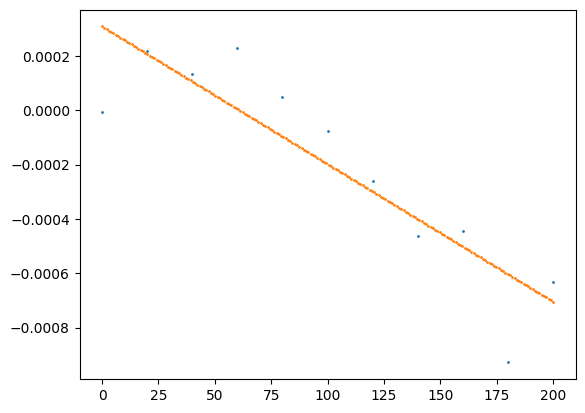

In [197]:
ures = (scaleDivision/np.sqrt(6))*np.ones((1,len(indicationPointsF)))

# Resultado de los paso 1 y 2

uexc = np.apply_along_axis(lambda row: row[1]*dEccentricityMax/(2*np.sqrt(3)*(nominalCalibrationMass/2+massCorrection)), 1, indicationPointsF)

# Resultado del paso 3 REVISAR
urep = np.max([S_Carg50,S_Carg100])*np.ones((1,len(indicationPointsF)))/np.sqrt(rep)

# Incertidumbre de excentricidad
u2l = ures**2+uexc**2+urep**2

utrazc = np.array(list(EMPs.items()))[:,1]/np.sqrt(3)

uder = np.array(list(EMPs.items()))[:,1]/(3*np.sqrt(3))

# REVISAR
uaire = 6.79e-4*paire
up = 70 # kg/m3

mref = np.apply_along_axis(lambda row: row[0]+EMPs[row[0]]+dmemp[row[0]], 1, indicationPointsF)

uempuje = np.sqrt((uaire*(1/ppesa-1/8000))**2+(up*(paire-1.2)/ppesa**2)**2)*mref

# No se usa, solo se usa en cabio de laboratorio
uconv = 0*np.ones((1,len(indicationPointsF)))

# Incertidumbre de masa de referencia
u2m = utrazc**2+uder**2+uempuje**2+uconv**2

# Incertidumbre combinada
ue = np.sqrt(u2m + u2l)


veff = (ue**4)/((urep**4)/(len(repetib100)-1)+(utrazc**4)/50)

# print(ue)

# print(veff)

k = np.apply_along_axis(lambda row: calculateK(row,0.9545), 0, veff)

# print(k)

U1 = k*ue

indicationError = np.concatenate([indicationPointsF[:,1],
                                  np.apply_along_axis(lambda row: row[1]-(row[0]+EMPs[row[0]]+dmemp[row[0]]), 1, indicationPointsF)]).reshape(2,len(indicationPointsF))


reg = scipy.stats.linregress(indicationError[0,:],indicationError[1,:])

print('''
      y = {0:.2E}*x + {1:.2E}
      r^2 = {2:.4f}
      '''.format(reg.slope,reg.intercept,reg.rvalue**2))

line = np.linspace(indicationError[0,0],indicationError[0,-1],200)*reg.slope + reg.intercept

plt.scatter(indicationError[0,:],indicationError[1,:],s=1)
plt.scatter(np.linspace(indicationError[0,0],indicationError[0,-1],200),line,s=1)

expectedError = indicationPointsF[:,1]*reg.slope + reg.intercept

dErrors = np.abs(indicationError[1,:]-expectedError)

maxDiff = np.max(dErrors)

ureg = maxDiff/np.sqrt(3)

ucf = np.sqrt(ureg**2 + ue**2)

Uf = (k*ucf)[0,:]

# print(Uf)

Uf = np.array([sigFigs(x,2) for x in Uf])

print(Uf)

